# calibration analysis

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from imblearn.under_sampling import RandomUnderSampler

# warnings.simplefilter('ignore', pd.errors.DtypeWarning)
sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))
# np.seterr(divide='ignore')
# warnings.simplefilter("ignore")

from TimeSeriesAnalysis.utils.data_load_save import *
from TimeSeriesAnalysis.auc_over_time_diff_prob import *
from TimeSeriesAnalysis.utils.diff_tracker_utils import *

import TimeSeriesAnalysis.params as params
import TimeSeriesAnalysis.consts as consts

/home/shakarch/.conda/envs/tf-env-new/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/shakarch/.conda/envs/tf-env-new/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/shakarch/.conda/envs/tf-env-new/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
clf, x_train, x_test, y_train, y_test = load_data(consts.intensity_model_path, load_clf=True, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)

In [243]:
def downsample(x,y):
    x = x.sort_values("Spot track ID")
    y = y.sort_values("Spot track ID")

    true = y[y==True]
    false = y[y==False]
    min_len = min([len(true), len(false)])
    true = true.sample(n=min_len, random_state=101)
    false = false.sample(n=min_len, random_state=101)
    y = pd.concat([true, false],axis=0)
    x = x[x["Spot track ID"].isin(y["Spot track ID"])]
    return x,y

In [244]:
# # Undersample imbalanced dataset with NearMiss-2
# from imblearn.under_sampling import NearMiss
# undersample = NearMiss(version=2, n_neighbors=3)

In [2]:
undersample = RandomUnderSampler(random_state=42)

# Train Models and get Probabilities

In [2]:
from sklearn.model_selection import train_test_split
clf, x_train, x_test, y_train, y_test = load_data(consts.intensity_model_path, load_clf=True, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
x_train = x_train.drop(columns=["Spot track ID"])
x_test = x_test.drop(columns=["Spot track ID"])

y_train = y_train["target"]
y_test = y_test["target"]

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.25, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: '/storage/users/assafzar/Muscle_Differentiation_AvinoamLab/_/_/17-01-2023-actin_intensity local dens-False, s%s, s%s train win size 27/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_//clf.joblib'

In [2]:
def plot_calibration_curve(y_true, not_calibrated_probs, calibrated_probs_sigmoid, calibrated_probs_isotonic, save_path, clf_score, clf_sigmoid_score, clf_isotonic_score):
    plt.figure(figsize=(10, 4))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    x, y = calibration_curve(y_true, not_calibrated_probs, n_bins=10, normalize=False)
    plt.plot(y, x, marker='.', label=f'original, brier={round(clf_score, 3)}')

    x, y = calibration_curve(y_true, calibrated_probs_sigmoid, n_bins=10, normalize=False)
    plt.plot(y, x, marker='.', label=f'sigmoid calibration, brier={round(clf_sigmoid_score, 3)}')

    x, y = calibration_curve(y_true, calibrated_probs_isotonic, n_bins=10, normalize=False)
    plt.plot(y, x, marker='.', label=f'isotonic calibration, brier={round(clf_isotonic_score, 3)}')

    plt.title("calibrated vs not calibrated curves", fontsize=20)
    plt.xlabel('Mean predicted probability for each bin', fontsize=14)
    plt.ylabel('fraction of positive classes in each bin', fontsize=14)
    plt.legend()
#     plt.savefig(save_path + "/calibration_curve.eps", format="eps")
    plt.show()
    plt.clf()

def plot_predicted_vs_empirical_probs(x_data, y_data, not_calibrated_clf, calibrated_clf, save_path):
    # Plot Predicted Probabilities vs Empirical Probabilities
    plt.figure(figsize=(20, 10))

    plt.subplot(3, 1, 1)
    sns.histplot(data=not_calibrated_clf.predict_proba(x_data)[:, 1])
    plt.title(f"test predicted probabilities (not calibrated)", fontsize=20)

    plt.subplot(3, 1, 2)
    sns.histplot(data=calibrated_clf.predict_proba(x_data)[:, 1])
    plt.title(f"test predicted probabilities (calibrated)", fontsize=20)

    plt.subplot(3, 1, 3)
    sns.histplot(data=y_data.astype(int))
    plt.title(f"test true values", fontsize=20)
    plt.tight_layout()
#     plt.savefig(save_path + "/calibration predicted probabilities.eps", format="eps")
    plt.show()
    plt.clf()


======= motility =======

With no calibration: 0.157
With sigmoid calibration: 0.164
With isotonic calibration: 0.160
CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=False,
                                                             max_depth=10),
                       cv=5)


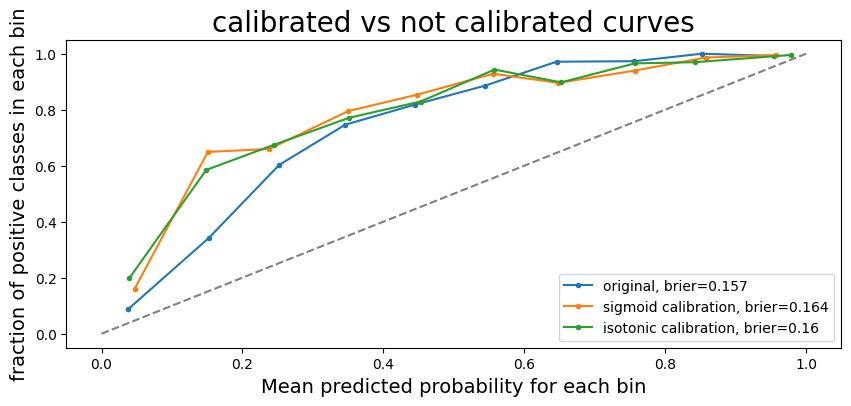


======= intensity =======

With no calibration: 0.099
With sigmoid calibration: 0.096
With isotonic calibration: 0.093
CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=False,
                                                             max_depth=40),
                       cv=5)


<Figure size 640x480 with 0 Axes>

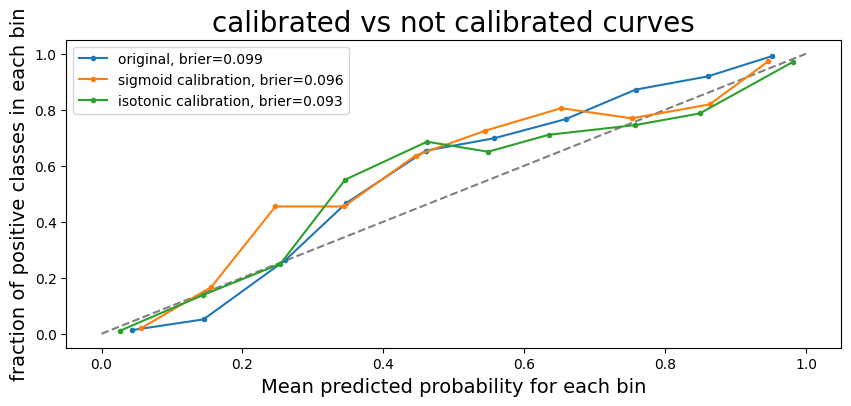

<Figure size 640x480 with 0 Axes>

In [70]:
from imblearn.ensemble import BalancedRandomForestClassifier

def calibrate_model(x_train, y_train, x_test, y_test, clf, path, modality):
    from imblearn.under_sampling import RandomUnderSampler
    undersample = RandomUnderSampler(random_state=42)
#     x_train, y_train = undersample.fit_resample(x_train, y_train) #todo remove
#     x_test, y_test = undersample.fit_resample(x_test, y_test) #todo remove
    
    params_dict = {"motility": {'bootstrap': False, 'max_depth': 10,  'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},
                 
                   
                   "actin_intensity": {'bootstrap': False, 'max_depth': 40, 'max_features': 'auto',
                                       'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}}
    
    params = params_dict.get(modality) if params_dict.get(modality) is not None else {}
    case_clf_not_fit = RandomForestClassifier(**params)
    base_clf = RandomForestClassifier(**params)
    base_clf.fit(x_train, y_train)
    not_calibrated_probs = base_clf.predict_proba(x_test)[:, 1]

    calibrated_model_sigmoid = CalibratedClassifierCV(case_clf_not_fit, cv=5, method="sigmoid")
    calibrated_model_sigmoid.fit(x_train, y_train)
    calibrated_probs_sigmoid = calibrated_model_sigmoid.predict_proba(x_test)[:, 1]
    calibrated_model_isotonic = CalibratedClassifierCV(case_clf_not_fit, cv=5, method="isotonic")
    calibrated_model_isotonic.fit(x_train, y_train)
    calibrated_probs_isotonic = calibrated_model_isotonic.predict_proba(x_test)[:, 1]

    # calculate brier score:
    clf_score = brier_score_loss(y_test, not_calibrated_probs)
    print("With no calibration: %1.3f" % clf_score, flush=True)
    clf_sigmoid_score = brier_score_loss(y_test, calibrated_probs_sigmoid)
    print("With sigmoid calibration: %1.3f" % clf_sigmoid_score, flush=True)
    clf_isotonic_score = brier_score_loss(y_test, calibrated_probs_isotonic)
    print("With isotonic calibration: %1.3f" % clf_isotonic_score, flush=True)

    # calibrate with best calibration method
    calibrated_model = calibrated_model_sigmoid
    print(calibrated_model)
    plot_calibration_curve(y_test, not_calibrated_probs, calibrated_probs_sigmoid, calibrated_probs_isotonic, path, clf_score, clf_sigmoid_score, clf_isotonic_score)
#     plot_predicted_vs_empirical_probs(x_test, y_test, base_clf, calibrated_model, path)
    return calibrated_model

print("\n======= motility =======\n")
motility_model_path = consts.motility_model_path%(1,5) # consts.storage_path + r"_/_/17-01-2023-motility local dens-False, s1, s5 train/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_"
clf, x_train, x_test, y_train, y_test = load_data(motility_model_path, load_clf=True, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
x_train = x_train.drop(columns=["Spot track ID"])
x_test = x_test.drop(columns=["Spot track ID"])
y_train = y_train["target"]
y_test = y_test["target"]

calibrated_model_mot = calibrate_model(x_train, y_train, x_test, y_test, clf, consts.motility_model_path%(1,5), "motility")

print("\n======= intensity =======\n")
_, x_train, x_test, y_train, y_test = load_data(consts.storage_path + r"_/_/15-01-2023-actin_intensity local dens-False, s1, s5 train win size 27/track len 30, impute_func-ImputeAllData_impute_zeroes reg MeanOpticalFlowReg_", load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
x_train = x_train.drop(columns=["Spot track ID"])
x_test = x_test.drop(columns=["Spot track ID"])
y_train = y_train["target"]
y_test = y_test["target"]

calibrated_model_int = calibrate_model(x_train, y_train, x_test, y_test, "", consts.intensity_model_path%(1,5), "actin_intensity")

# Calibrate

# Plot Predicted Probabilities vs Empirical Probabilities